## **************************************************************Modeling**************************************************************

## Imports

In [6]:
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Model, Sequential
from keras.layers import Activation, Dense, LSTM, Embedding, TimeDistributed, recurrent
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras import regularizers

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost.sklearn import XGBRegressor
import catboost
from catboost import CatBoostRegressor
import numpy as np
from scipy.stats import spearmanr
from sklearn.cluster import DBSCAN
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import shap
shap.initjs()
import lime
import lime.lime_tabular

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 85% !important; }</style>"))

## Missing Packages Installation

In [82]:
! pip install seaborn
! pip install lightgbm
! pip install shap
! pip install lime
!pip install catboost

## Google Drive Mounting (When executed in google colab):

In [81]:
from google.colab import drive
drive.mount('/content/drive')

## Load Data:

In [84]:
X_train = pd.read_pickle("Selected_X_train.pkl")
X_test = pd.read_pickle("Selected_X_test.pkl")
y_train = np.array(pd.read_pickle("Selected_y_train.pkl") * 100).reshape(-1,)
y_test = np.array(pd.read_pickle("Selected_y_test.pkl") * 100).reshape(-1,)

#### Rename columns

In [122]:
new_cols = {}
for i in X_train.columns:
    new_cols[i] = i.replace('(','_').replace(')','_').replace('[','_').replace(']','_')

In [126]:
X_train = X_train.rename(columns=new_cols)

In [127]:
X_test = X_test.rename(columns=new_cols)

## Data Integrity Checks

In [85]:
# check same length of samples and labels
# train
assert X_train.shape[0] == y_train.shape[0]
# test
assert X_test.shape[0] == y_test.shape[0]

# check same features
assert X_train.shape[1] == X_test.shape[1]

## Baseline prediction

In [1]:
y_baseline = np.full(y_test.shape,y_train.mean())

print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_baseline))}')
print(f'MAE: {mean_absolute_error(y_test, y_baseline)}')
print(f'R-Squared: {r2_score(y_test, y_baseline)}')
print(f'Pearson Correlation: {np.corrcoef(y_test.reshape(-1,), y_baseline.reshape(-1,))[0,1]}')
# print(f'Spearman correlation: {spearmanr(y_test, y_baseline)[0]}')

## Modeling

- The following models are tested: Linear Regression (Normalized), Linear Regression (Un-Normalized), ElasticNet, Random Forest Regressor, CatBoost Regressor, XGBoost Regressor, Simple Neural Network and LGBM
- Performance is measured by RMSE, MSE, R-Squraed, Pearson Correlation and Spearman Correlation
- Validation and Hyper-Parameter searching is done using Sklearn RandomizedSearchCV

## Linear Regression (Normalized)

In [87]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(normalize=True).fit(X_train, y_train)
y_pred_lin_reg_norm = reg.predict(X_test)

In [88]:
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lin_reg_norm))}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_lin_reg_norm)}')
print(f'R-Squared: {r2_score(y_test, y_pred_lin_reg_norm)}')
print(f'Pearson Correlation: {np.corrcoef(y_test, y_pred_lin_reg_norm)[0,1]}')
print(f'Spearman correlation: {spearmanr(y_test, y_pred_lin_reg_norm)[0]}')

RMSE: 26.004793144365077
MAE: 20.462086784902016
R-Squared: 0.04099895924808705
Pearson Correlation: 0.20547493203631886
Spearman correlation: 0.18650523427029522


## Linear Regression (Un-Normalized)

In [89]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(normalize=False).fit(X_train, y_train)
y_pred_lin_reg = reg.predict(X_test)
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lin_reg))}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_lin_reg)}')
print(f'R-Squared: {r2_score(y_test, y_pred_lin_reg)}')
print(f'Pearson Correlation: {np.corrcoef(y_test, y_pred_lin_reg)[0,1]}')
print(f'Spearman correlation: {spearmanr(y_test, y_pred_lin_reg)[0]}')

RMSE: 26.004793144365077
MAE: 20.462086784902016
R-Squared: 0.04099895924808705
Pearson Correlation: 0.2054749320363184
Spearman correlation: 0.18650523427029522


## ElasticNet

#### ElasticNet RandomizedSearchCV

In [2]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV

# Use randomized search to tune the parameters:

params = {"l1_ratio": np.arange(0,1.01,0.05),
                  "alpha": [0.00001,0.00003,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100,300],
                  "warm_start": [True,False],
                  "selection": ['random', 'cyclic']}

eNet = ElasticNet()
elastic_net_rnd = RandomizedSearchCV(eNet, params, scoring='r2',
                                     n_jobs = -1, verbose = 2)
elastic_net_rnd.fit(X_train, y_train)
y_pred_elasticnet = elastic_net_rnd.predict(X_test)

In [3]:
print(elastic_net_rnd.best_score_)
print(elastic_net_rnd.best_params_)

#### ElasticNet run on best parameters

In [57]:
eNet_best = ElasticNet(warm_start= False, selection= 'random', l1_ratio= 0.95, alpha= 0.0003)
eNet_best.fit(X_train, y_train)
y_pred_elasticnet = eNet_best.predict(X_test)

In [58]:
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_elasticnet))}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_elasticnet)}')
print(f'R-Squared: {r2_score(y_test, y_pred_elasticnet)}')
print(f'Pearson Correlation: {np.corrcoef(y_test, y_pred_elasticnet)[0,1]}')
print(f'Spearman correlation: {spearmanr(y_test, y_pred_elasticnet)[0]}')

RMSE: 25.99106802645489
MAE: 20.449620088162508
R-Squared: 0.04201099797363306
Pearson Correlation: 0.2064435590186109
Spearman correlation: 0.1868460390207612


## Random Forest Regressor

#### Random Forest Regressor RandomizedSearchCV

In [4]:
# Create the parameter grid based on the results of random search 
# Consider using tree pruning
rf = RandomForestRegressor()
params = {
    'criterion': ['mse'],
    'bootstrap': [True],
    'max_depth': np.arange(2,50,7),
    'max_features': np.arange(5,115,20),
    'min_samples_leaf': np.arange(2,10,1),
    'min_samples_split': np.arange(2,40,10),
    'n_estimators': [10, 40, 70, 100]
}
rnd_forest_src = RandomizedSearchCV(rf, params, scoring='r2',verbose = 5)

# Fit the grid search to the data
rnd_forest_src.fit(X_train, y_train)
print(rnd_forest_src.best_params_)
best_grid = rnd_forest_src.best_estimator_
y_pred_rnd_forest = rnd_forest_src.predict(X_test)

In [117]:
rf_best = RandomForestRegressor(n_estimators=300, min_samples_split=22,min_samples_leaf=2,max_features=75,
                               max_depth=30,criterion='mse',bootstrap=True)
rf_best.fit(X_train, y_train)
y_pred_rnd_forest = rf_best.predict(X_test)

In [118]:
print(rnd_forest_src.best_score_)
print(rnd_forest_src.best_params_)

0.06907133903610459
{'n_estimators': 100, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 85, 'max_depth': 37, 'criterion': 'mse', 'bootstrap': True}


#### Random Forest Regressor run on best parameters

In [119]:
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rnd_forest))}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_rnd_forest)}')
print(f'R-Squared: {r2_score(y_test, y_pred_rnd_forest)}')
print(f'Pearson Correlation: {np.corrcoef(y_test, y_pred_rnd_forest)[0,1]}')
print(f'Spearman correlation: {spearmanr(y_test, y_pred_rnd_forest)[0]}')

RMSE: 25.565429866775602
MAE: 20.15871246527234
R-Squared: 0.07313075785564094
Pearson Correlation: 0.2741871900661838
Spearman correlation: 0.2393779189778951


## CatBoost Regressor

In [7]:
cat_model = CatBoostRegressor(learning_rate=0.08, iterations=5000, custom_metric=['RMSE'], eval_metric='RMSE', verbose=1000)

cat_model.fit(X_train, y_train)

In [158]:
cat_preds = cat_model.predict(X_test)

In [159]:
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, cat_preds))}')
print(f'MAE: {mean_absolute_error(y_test, cat_preds)}')
print(f'R-Squared: {r2_score(y_test, cat_preds)}')
print(f'Pearson Correlation: {np.corrcoef(y_test, cat_preds)[0,1]}')
print(f'Spearman correlation: {spearmanr(y_test, cat_preds)[0]}')

RMSE: 25.385088391086175
MAE: 19.887221354694496
R-Squared: 0.08616112031490797
Pearson Correlation: 0.30098552017687136
Spearman correlation: 0.26099433554067775


## XGBoost Regressor

 #### XGBoost RandomizedSearchCV

In [128]:
X_train_arr = np.array(X_train)
X_test_arr = np.array(X_test)

In [1]:
# Various hyper-parameters to tune
xgb = XGBRegressor()
params = {'objective':['reg:squarederror', 'reg:gamma','rank:ndcg','reg:squarederror','rank:pairwise'],
              'learning_rate': [0.001,0.003,0.01,0.03,0.1,0.3,1],
              'max_depth': np.arange(2,50,5),
              'subsample': [1], # Reduce to prevent overfitting
              'colsample_bytree': [1]} # Reduct to prevent overfitting

xgb_rnd = RandomizedSearchCV(xgb, params, scoring='r2', verbose = 5)

xgb_rnd.fit(X_train,y_train)
y_pred_xgb = xgb_rnd.predict(X_test)
print(xgb_rnd.best_score_)
print(xgb_rnd.best_params_)

#### XGBoost Run on best parameters

In [ ]:
xgb_best = XGBRegressor(subsample= 1, objective= 'reg:squarederror', max_depth= 7, learning_rate= 0.1, 
                   colsample_bytree= 1)
xgb_best.fit(X_train,y_train)
y_pred_xgb = xgb_best.predict(X_test)

In [ ]:
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb))}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_xgb)}')
print(f'R-Squared: {r2_score(y_test, y_pred_xgb)}')
print(f'Pearson Correlation: {np.corrcoef(y_test, y_pred_xgb)[0,1]}')
print(f'Spearman correlation: {spearmanr(y_test, y_pred_xgb)[0]}')

## Neural Network

In [94]:
# Neural network
nn = Sequential()
nn.add(Dense(128, input_dim=X_train.shape[1], activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
nn.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
nn.add(Dense(1,activation='linear', kernel_regularizer=regularizers.l2(0.0001)))

In [95]:
nn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               91904     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 100,225
Trainable params: 100,225
Non-trainable params: 0
_________________________________________________________________


In [96]:
nn.compile(loss = 'mean_absolute_error', optimizer = 'adam')

In [97]:
stop = EarlyStopping(monitor='val_loss', min_delta=0, 
                         patience=5, verbose=1, mode='auto',
                         baseline=None, restore_best_weights=True)

In [98]:
nn.compile(loss='mean_absolute_error', optimizer='adam')

In [8]:
nn.fit(X_train, y_train, epochs=100, batch_size=10,validation_split = 0.2, callbacks = [stop])

In [100]:
y_pred_nn = nn.predict(X_test)

In [101]:
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_nn))}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_nn)}')
print(f'R-Squared: {r2_score(y_test, y_pred_nn)}')
print(f'Pearson Correlation: {np.corrcoef(y_test, y_pred_nn.reshape(-1,))[0,1]}')
print(f'Spearman correlation: {spearmanr(y_test, y_pred_nn.reshape(-1,))[0]}')

RMSE: 26.578326135229172
MAE: 20.25068086653177
R-Squared: -0.0017688516607381466
Pearson Correlation: 0.18680023968761172
Spearman correlation: 0.1739715803741491


## Light GBM

In [9]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(np.array(X_train), y_train)
lgb_eval = lgb.Dataset(np.array(X_test), y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'num_iterations': 300
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

print('Saving model...')
# save model to file
gbm.save_model('model.txt')

print('Starting predicting...')
# predict
y_pred_lgbm = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred_lgbm) ** 0.5)

In [107]:
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lgbm))}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_lgbm)}')
print(f'R-Squared: {r2_score(y_test, y_pred_lgbm)}')
print(f'Pearson Correlation: {np.corrcoef(y_test, y_pred_lgbm.reshape(-1,))[0,1]}')
print(f'Spearman correlation: {spearmanr(y_test, y_pred_lgbm.reshape(-1,))[0]}')

RMSE: 25.688054630038053
MAE: 20.2086843819649
R-Squared: 0.0642179642452092
Pearson Correlation: 0.2599348560665635
Spearman correlation: 0.22760238285543669


## Results summary & analysis

#### Storing Results in a DataFrame

In [160]:
results = pd.concat([pd.Series(y_baseline, name ='baseline'),pd.Series(y_pred_lin_reg_norm, name ='lin_reg_norm'),
             pd.Series(y_pred_lin_reg, name ='lin_reg'),pd.Series(y_pred_elasticnet, name ='elasticnet'),
             pd.Series(y_pred_lgbm.reshape(-1,), name ='lgbm'),pd.Series(y_pred_nn.reshape(-1,), name ='nn'),
             pd.Series(y_pred_rnd_forest, name ='rnd_forest'),
                     pd.Series(cat_preds, name ='cat_boost'),
             pd.Series(y_test, name ='true_values')
              ],axis = 1)

#### Storing Results in a Pickle

In [198]:
pd.to_pickle(results, "results.pkl")

#### Predicted values distribution (Box plot):

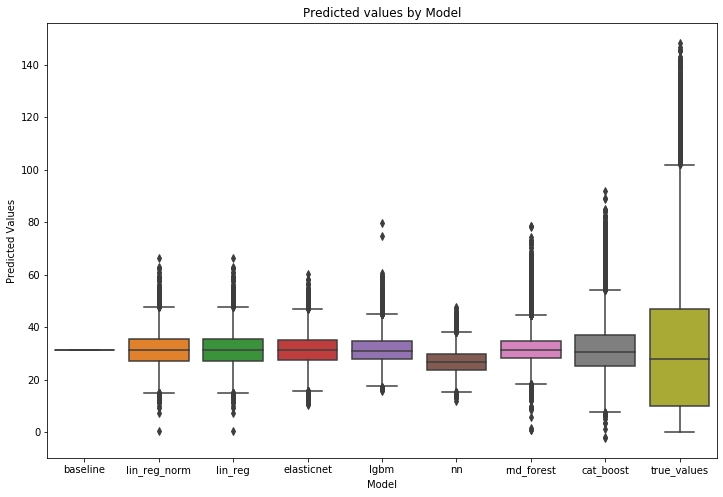

In [163]:
plt.figure(figsize=(12,8))
ax = sns.boxplot(data=results)
ax.set_title('Predicted values by Model')
ax.set_xlabel('Model')
ax.set_ylabel('Predicted Values')
plt.show();

#### Comparing performance by Spearman Correlation

- CatBoost have the best performance

In [164]:
df=pd.DataFrame(columns=["model","spearman"])
for col in results.columns:
    df=df.append({"model":col, "spearman":np.corrcoef(y_test, results[col])[0,1]}, ignore_index=True)
df = df.sort_values('spearman')

In [175]:
df_rmse=pd.DataFrame(columns=["model","rmse"])
for col in results.columns:
    df_rmse=df_rmse.append({"model":col, "rmse":np.sqrt(mean_squared_error(y_test, results[col]))}, ignore_index=True)
df_rmse = df_rmse.sort_values('rmse')

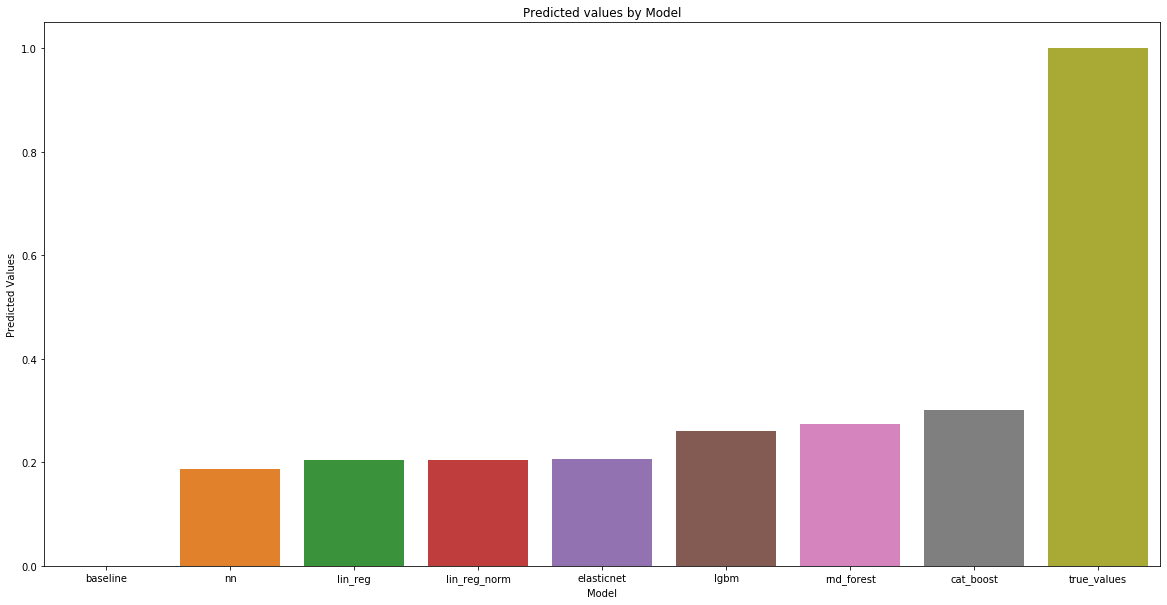

In [179]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x="model", y="spearman", data=df)
ax.set_title('Predicted values by Model')
ax.set_xlabel('Model')
ax.set_ylabel('Predicted Values')
plt.show();

#### True values vs. Predicted values

- No special Pattern

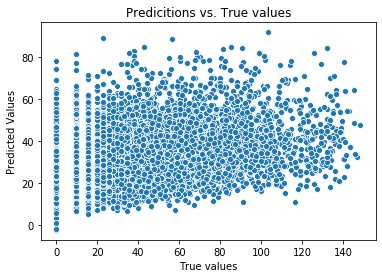

In [178]:
ax = sns.scatterplot(x=y_test, y=cat_preds)
ax.set_title('Predicitions vs. True values')
ax.set_xlabel('True values')
ax.set_ylabel('Predicted Values')
plt.show();

#### Model interpretation - Feature impact on target variable

- Proper Nouns (Names of people, places etc.) have strong positive impact on joke score
- Existance of words with similar meaning has strong positive impact on joke score
- Longer jokes are funnier
- Existance of words with clear sentiment (High polarity) has a positive impact on joke score
- The word 'able' has the strongest positive impact,  among all other common words

In [170]:
shap_explainer = shap.TreeExplainer(rf_best.estimators_[1])
shap_values = shap_explainer.shap_values(X_test[:3000])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


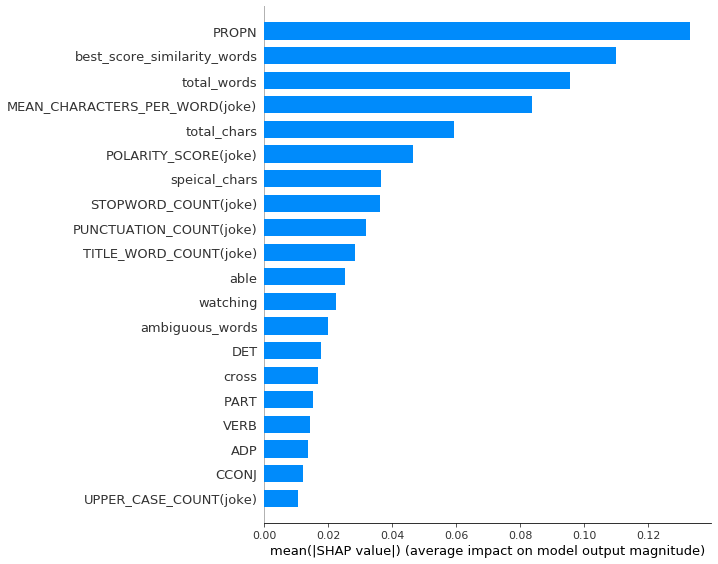

In [38]:
shap.summary_plot(shap_values,X_train,plot_type='bar')